# Create Linear decoupled ode system to learn

In [ ]:
import jax
import jax.numpy as jnp
import diffrax
from jax.scipy.linalg import block_diag
import matplotlib.pyplot as plt

def linear_system(t,y,args):
    A1, A2, A3 = args
    A = block_diag(A1,A2,A3)

    return A @ y



In [31]:
A1 = jnp.array([[0, 1],
                [-2, -3]])
A2 = jnp.array([[0, -1],
                [4,  0]])
A3 = jnp.array([[-1, 2],
                [-2, -1]])

args = (A1, A2, A3)
t0 = 0
t1 = 20.01
dt=0.01
y0=jnp.array([1., 0., 0., 1., -1., 0.])

In [ ]:
linear_system(0,y0,args)

(Array([ 0., -2., -1.,  0.,  1.,  2.], dtype=float32),
 Array([ 0. , 26. , -7.3], dtype=float32))

In [33]:
save_at = diffrax.SaveAt(dense=True)

ode_term = diffrax.ODETerm(linear_system)
solver = diffrax.Tsit5()

sol = diffrax.diffeqsolve(
    ode_term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=y0,
    args=args,
    saveat=save_at,
    max_steps=int(10*(t1-t0)/dt)
)

In [3]:
from data.linear import solve_linear

sol = solve_linear()


In [5]:
t = jnp.arange(0,20,0.01)
t.shape

(2000,)

In [6]:
output = jax.vmap(sol.evaluate)(t)

In [1]:
from exp.expdata import LinearExp
exp = LinearExp()

In [2]:
exp.x_true.shape
t = exp.t_true

In [6]:
exp.true_coeff = exp.generate_true_coeff()

In [7]:
exp.print()

(x0)' = 1.000 x1
(x1)' = -2.000 x0 + -3.000 x1
(x2)' = -1.000 x3
(x3)' = 4.000 x2
(x4)' = -1.000 x4 + 2.000 x5
(x5)' = -2.000 x4 + -1.000 x5


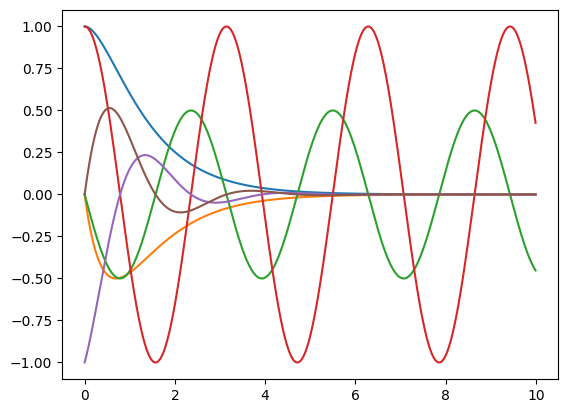

In [3]:
import matplotlib.pyplot as plt
for xi in exp.x_true.T:
    plt.plot(t,xi)
    # plt.show()
    


In [12]:
import pysindy as ps
lib = ps.PolynomialLibrary()

In [13]:
lib.fit(exp.x_train)

,degree,2
,include_interaction,True
,interaction_only,False
,include_bias,True
,order,'C'


In [14]:
feat_names = lib.get_feature_names()

In [19]:
len(feat_names), feat_names

(28,
 ['1',
  'x0',
  'x1',
  'x2',
  'x3',
  'x4',
  'x5',
  'x0^2',
  'x0 x1',
  'x0 x2',
  'x0 x3',
  'x0 x4',
  'x0 x5',
  'x1^2',
  'x1 x2',
  'x1 x3',
  'x1 x4',
  'x1 x5',
  'x2^2',
  'x2 x3',
  'x2 x4',
  'x2 x5',
  'x3^2',
  'x3 x4',
  'x3 x5',
  'x4^2',
  'x4 x5',
  'x5^2'])

In [31]:
import numpy as np
theta = np.zeros((6, 28))

In [32]:
exp.A1

Array([[ 0,  1],
       [-2, -3]], dtype=int64)

In [35]:
theta[:2,1:3]  = exp.A1
theta[2:4,3:5] = exp.A2
theta[4:6,5:7] = exp.A3

In [1]:
theta

NameError: name 'theta' is not defined

## June 24

In [ ]:
import jax
jax.config.update('jax_enable_x64',True)

from jsindy import JSINDyModel
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.optim import LMSettings, AlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ

from exp.evaluate.jsindy import evaluate_model
from exp.expdata import LinearExp

In [2]:
expdata = LinearExp(t1=20, seed=420, n_colloc=200)

In [3]:

trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight =  100.
colloc_weight = 100.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = .1))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.01,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

In [4]:
metrics = evaluate_model(model,expdata)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Restart 1
{'show_progress': True, 'sigma2_est': Array(1.e-08, dtype=float64), 'data_weight': 100.0, 'colloc_weight': 100.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 5.316, gradnorm = 5.39e+04, alpha = 4.167, improvement_ratio = 1.003
Iteration 1, loss = 3.396, gradnorm = 2.357e+03, alpha = 3.472, improvement_ratio = 1.002
Iteration 2, loss = 2.818, gradnorm = 193.6, alpha = 2.894, improvement_ratio = 1.001
Iteration 3, loss = 2.53, gradnorm = 48.18, alpha = 2.411, improvement_ratio = 1.001
Iteration 4, loss = 2.347, gradnorm = 24.34, alpha = 2.009, improvement_ratio = 1.001
Iteration 5, loss = 2.214, gradnorm = 17.43, alpha = 1.674, improvement_ratio = 1.001
Line Search Failed!
Final Iteration Results
Iteration 43, loss = 1.508, gradnorm = 0.0003266, alpha = 2.293e+03, improvement_ratio = -2.645e+03
Model after smooth warm start
(x0)' = 0.001 1 + -0.434 x0 + 0.547 x1 + -0.057 x4 + 0.012 x5 + 0.129 x0^2 + -0.016 x0 x1 + 0.024 x0 x3 + -0.080 x0 x4 + 0.048 x0 x5 + -0.009 x1^2 + -0.012 x1 x2 + 0.067 x1 x3 + -0.017 x1 x4 + -0.026 x1 x5 + -0.003 x2^2 + 0.020 x2 x4 + 0.072 x2 x5 + -0.001 x3^2 + 0.020 x3 x4 + 0.020 x3 x5 + 0.074 x4^2 +

In [5]:
model.print()

(x0)' = 1.000 x1
(x1)' = -1.081 x1 + 0.152 x4 + -0.917 x0^2 + 0.103 x0 x4 + -0.548 x4^2
(x2)' = -1.000 x3
(x3)' = 4.000 x2
(x4)' = 4.204 x5 + 0.547 x0^2 + 7.719 x0 x2 + 0.770 x0 x3 + 5.810 x1 x2
(x5)' = -1.267 x4 + -1.641 x5 + -0.808 x0 x2 + 0.282 x0 x3 + -0.533 x0 x4 + -0.043 x4^2


In [6]:
expdata.print()

(x0)' = 1.000 x1
(x1)' = -2.000 x0 + -3.000 x1
(x2)' = -1.000 x3
(x3)' = 4.000 x2
(x4)' = -1.000 x4 + 2.000 x5
(x5)' = -2.000 x4 + -1.000 x5


In [7]:
expdata.x_train.shape

(200, 6)

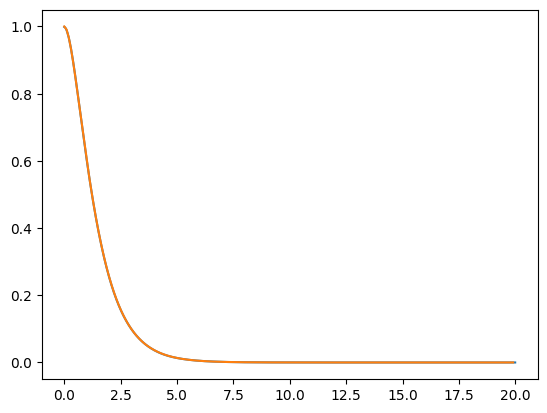

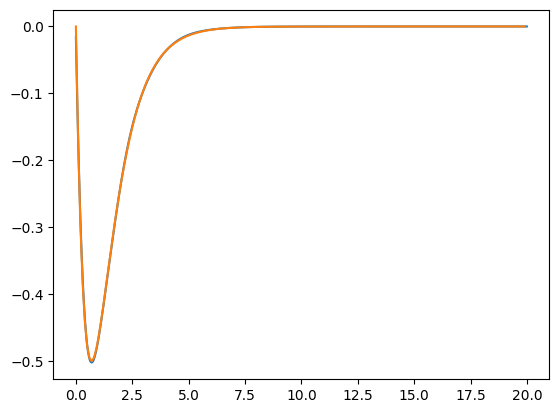

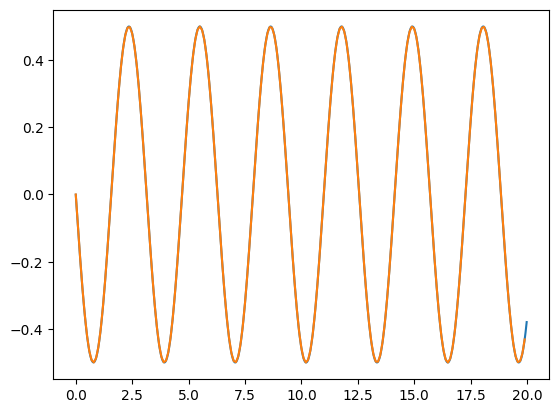

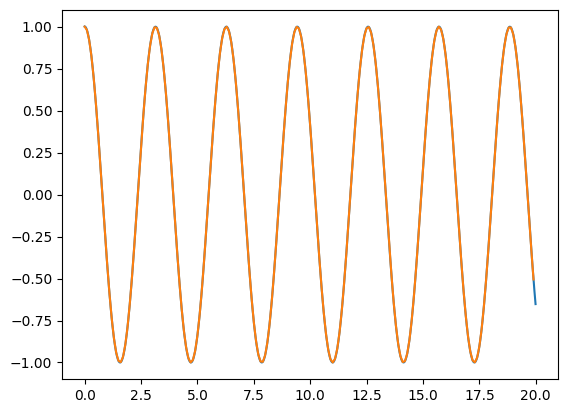

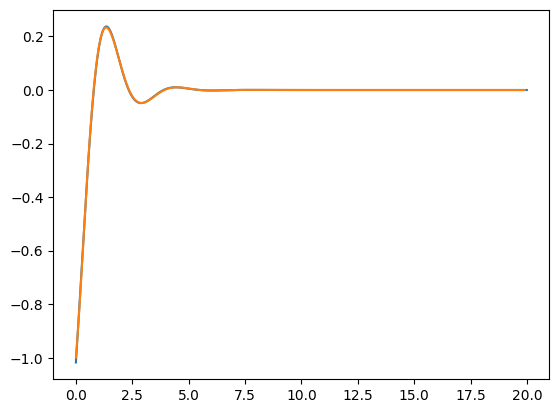

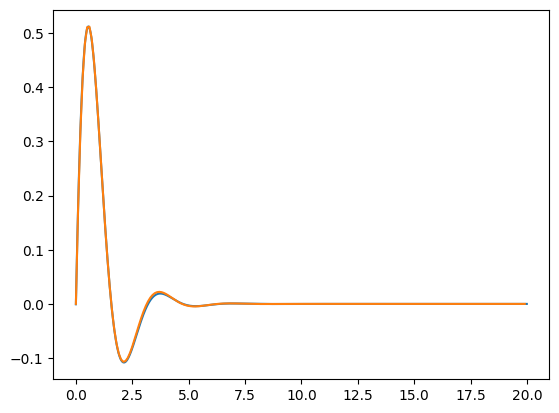

In [8]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.plot(expdata.t_true,model.predict_state(expdata.t_true)[:,i])
    plt.plot(expdata.t_train,expdata.x_train_true[:,i])
    plt.show()

In [13]:
import pandas as pd

In [28]:
pd.DataFrame(metrics["x_metrics"],index=[0])

,mse,rmse,mae,max_abs_error,normalized_mse,relative_l2_error
0,1.1228390451645355e-06,0.00106,0.000329,0.017846,9.512066763030962e-06,0.003084


Debug

In [1]:

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from exp.expdata import LinearExp
from exp.evaluate.jsindy import evaluate_jmodel
import pickle
import jax.numpy as jnp

import time
def create_linear_experiment_data(noise, dt):
    initial_state = jnp.array([1., 0., 0., 1., -1., 0.])
    # sigma^2 - var
    true_sigma2 = noise
    t0=0
    t1=10.1
    n_train = len(jnp.arange(t0,t1,dt))

    n_colloc = 500
    expdata = LinearExp(
        initial_state=initial_state,
        t0=t0,
        t1=t1,
        dt = 0.01,
        dt_train=dt,
        noise= jnp.sqrt(true_sigma2),
        seed=29,
        n_colloc=n_colloc,
        one_rkey=True,
        # feature_names=['x','y','z']
    )
    return expdata

def create_jsindy_model(feature_names = None):
    trajectory_model = CholDataAdaptedRKHSInterpolant()
    dynamics_model = FeatureLinearModel(
        reg_scaling = 1.,
        feature_map=PolyLib(degree=1)
    )
    optsettings = LMSettings(
        max_iter = 2000,
        show_progress=True,
        no_tqdm=False,
        min_alpha = 1e-16,
        init_alpha = 5.,
    )
    data_weight =  1.
    colloc_weight = 100.
    sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = .01))
    optimizer = AlternatingActiveSetLMSolver(
            beta_reg=0.01,
            solver_settings=optsettings,
            fixed_colloc_weight=colloc_weight,
            fixed_data_weight=data_weight,
            sparsifier = sparsifier
            )
    
    model = JSINDyModel(
        trajectory_model=trajectory_model,
        dynamics_model=dynamics_model,
        optimizer=optimizer,
        feature_names=feature_names
    )
    return model



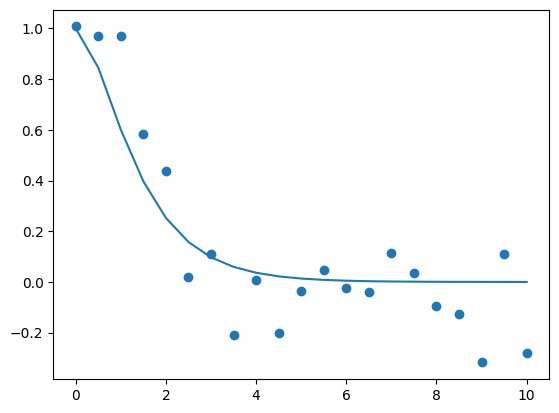

: 

In [ ]:
noise = jnp.array([0,0.01,0.05,0.1])
dt = jnp.array([0.05, 0.1, 0.2,0.5])

data = create_linear_experiment_data(noise[2],dt[3])

import matplotlib.pyplot as plt
for i in range(1):
    # plt.plot(expdata.t_true,jmodel.predict_state(expdata.t_true)[:,i])
    plt.plot(data.t_train, data.x_train_true[:,i])
    plt.scatter(data.t_train,data.x_train[:,i])
plt.show()

In [2]:
noise_vars = jnp.linspace(0,20,11)
dt_vals = jnp.around(jnp.linspace(0,0.2,11)[1:],4)

In [3]:
noise_vars[::-1], dt_vals[::-1]

(Array([20., 18., 16., 14., 12., 10.,  8.,  6.,  4.,  2.,  0.], dtype=float64),
 Array([0.2 , 0.18, 0.16, 0.14, 0.12, 0.1 , 0.08, 0.06, 0.04, 0.02],      dtype=float64))

In [15]:
jnp.linspace(0,0.2,4), jnp.linspace(0,0.2,4)

(Array([0.        , 0.06666667, 0.13333333, 0.2       ], dtype=float64),
 Array([0.        , 0.06666667, 0.13333333, 0.2       ], dtype=float64))

In [2]:
expdata = create_linear_experiment_data(.05,0.1)

In [3]:
jmodel = create_jsindy_model(expdata.feature_names)

In [4]:
expdata.x_train.flatten().shape, expdata.t_train.shape, expdata.t_colloc.shape

((606,), (101,), (500,))

In [5]:
metrics = evaluate_jmodel(jmodel,expdata)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.04758533, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 70.44, gradnorm = 7.448e+03, alpha = 4.167, improvement_ratio = 0.9889
Iteration 1, loss = 15.32, gradnorm = 839.4, alpha = 3.472, improvement_ratio = 0.9969
Iteration 2, loss = 14.81, gradnorm = 55.78, alpha = 2.894, improvement_ratio = 0.9913
Iteration 3, loss = 14.63, gradnorm = 17.28, alpha = 2.411, improvement_ratio = 0.9819
Iteration 4, loss = 14.5, gradnorm = 13.7, alpha = 2.009, improvement_ratio = 0.9806
Iteration 5, loss = 14.41, gradnorm = 10.17, alpha = 1.674, improvement_ratio = 0.9799
Iteration 75, loss = 14.07, gradnorm = 8.85e-09, alpha = 5.467e-05, improvement_ratio = 2.0
Model after smooth warm start
(x0)' = 0.014 1 + -0.322 x0 + 1.019 x1 + -0.011 x2 + -0.001 x3 + 0.084 x4 + 0.256 x5
(x1)' = -0.022 1 + -0.189 x0 + -0.857 x1 + 0.104 x2 + -0.059 x3 + 0.940 x4 + -0.396 x5
(x2)' = -0.032 1 + 0.074 x0 + -0.473 x1 + 0.138 x2 + -0.973 x3 + 0.282 x4 + -0.479 x5
(x3)' = 0.096 1 + -0.604 x0 + -0.602 x1 + 4.322 x2 + -0.171 x3 + -0.348 x4 + 0.612 x5
(x4)' = 0.

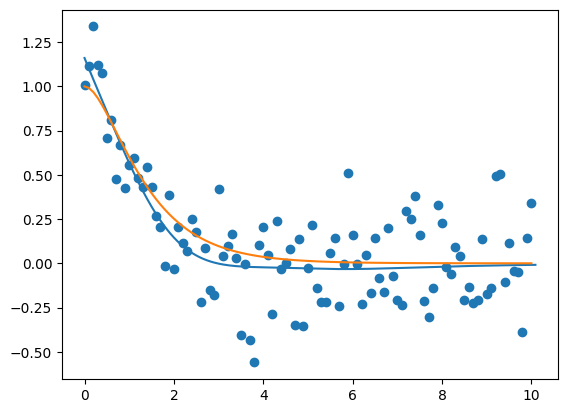

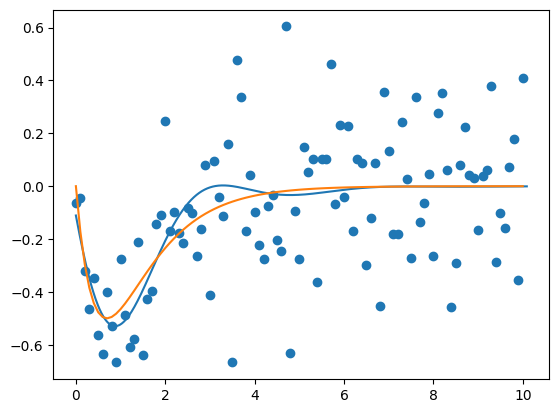

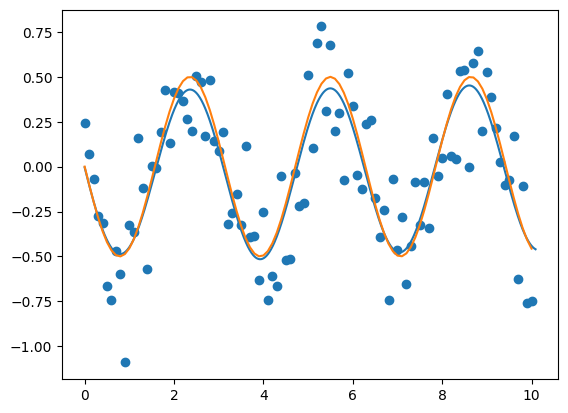

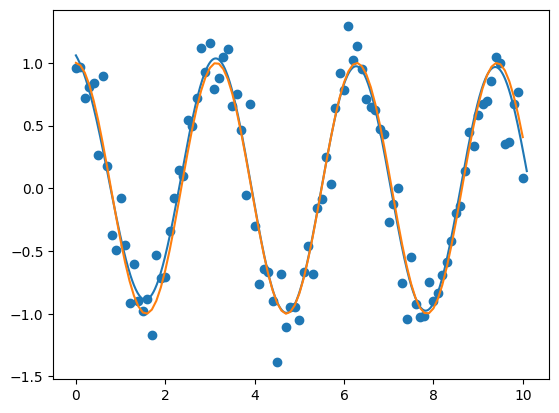

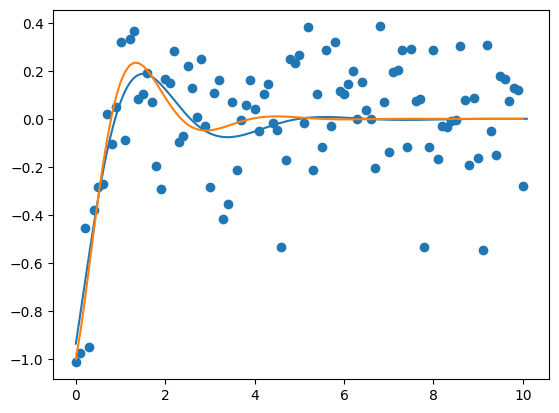

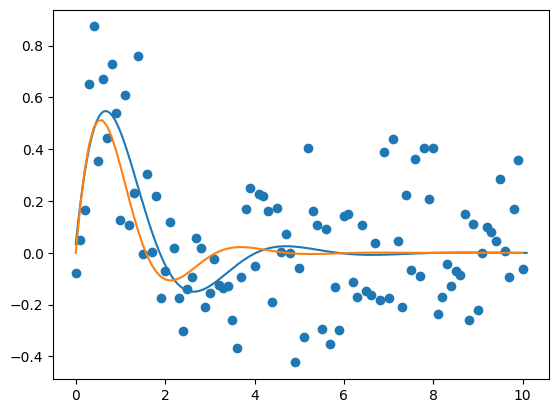

In [11]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.plot(expdata.t_true,jmodel.predict_state(expdata.t_true)[:,i])
    plt.plot(expdata.t_train, expdata.x_train_true[:,i])
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.show()

In [8]:
jmodel.print()

(x0)' = -0.462 x0 + 0.905 x1 + 0.399 x5
(x1)' = -0.864 x1 + 1.040 x4 + -0.895 x5
(x2)' = -0.364 x1 + -0.958 x3 + -0.417 x5
(x3)' = -2.048 x0 + -3.001 x1 + 4.252 x2 + -1.545 x4
(x4)' = -1.268 x4 + 1.266 x5
(x5)' = 0.585 x1 + -1.837 x4


In [ ]:
jmodel.theta.shape

(7, 6)

In [9]:
expdata.print()

(x0)' = 1.000 x1
(x1)' = -2.000 x0 + -3.000 x1
(x2)' = -1.000 x3
(x3)' = 4.000 x2
(x4)' = -1.000 x4 + 2.000 x5
(x5)' = -2.000 x4 + -1.000 x5


In [10]:
metrics["xdot_metrics"]

{'mse': Array(0.0092164, dtype=float64),
 'rmse': np.float64(0.0960020992591205),
 'mae': np.float64(0.05403056759396243),
 'max_abs_error': np.float64(0.9603666004645819),
 'normalized_mse': Array(0.01953193, dtype=float64),
 'relative_l2_error': np.float64(0.13969286449602883)}

# Lorenz speed test

In [1]:

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from exp.expdata import LinearExp, LorenzExp
from exp.evaluate.jsindy import evaluate_jmodel
import pickle
import jax.numpy as jnp

initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = 1
dt = 0.1
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = LorenzExp(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight =  1.
colloc_weight = 50.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = 1.))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.30026354, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 1.258e+05, gradnorm = 8.533e+06, alpha = 4.167, improvement_ratio = 0.9859
Iteration 1, loss = 4.118e+04, gradnorm = 8.426e+06, alpha = 4.167, improvement_ratio = 0.6735
Iteration 2, loss = 1.174e+03, gradnorm = 1.064e+07, alpha = 3.472, improvement_ratio = 0.9755
Iteration 3, loss = 547.9, gradnorm = 1.26e+06, alpha = 3.472, improvement_ratio = 0.6169
Iteration 4, loss = 181.9, gradnorm = 1.018e+06, alpha = 2.894, improvement_ratio = 0.9282
Iteration 5, loss = 170.6, gradnorm = 2.339e+05, alpha = 2.894, improvement_ratio = 0.3435
Line Search Failed!
Final Iteration Results
Iteration 91, loss = 132.7, gradnorm = 0.004842, alpha = 3.99e+05, improvement_ratio = -inf
Model after smooth warm start
(x)' = -2.142 1 + -11.029 x + 10.691 y + -0.295 z + -0.292 x^2 + 0.379 x y + 0.014 x z + -0.113 y^2 + -0.013 y z + 0.021 z^2
(y)' = -7.650 1 + 30.290 x + -3.066 y + 1.696 z + 0.316 x^2 + -0.079 x y + -1.082 x z + -0.092 y^2 + 0.076 y z + -0.062 z^2
(z)' = 4.625 1 + 3.151 x + -